In [1]:
import json
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [3]:
# Step 1: Load the data from JSON
with open("RandomNamesNEW.json", 'r') as json_file:
    data = json.load(json_file)

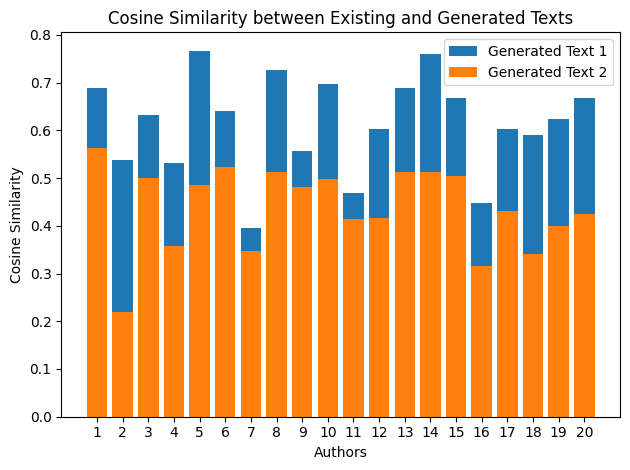

In [10]:
# Custom tokenizer that splits on whitespace
def tokenizer(text):
    return text.split()

# List to store cosine similarity scores
cosine_sims_existing = []
cosine_sims_generated1 = []
cosine_sims_generated2 = []

# Iterate over each entry in the JSON data
for i, entry in enumerate(data):
    existing_text = entry['existing_text']
    generated_text1 = entry['generated_text1']
    generated_text2 = entry['generated_text2']

    # Remove empty documents
    existing_text = existing_text.strip()
    generated_text1 = generated_text1.strip()
    generated_text2 = generated_text2.strip()

    # Create TfidfVectorizer object with custom tokenizer
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

    # Fit and transform the existing and generated texts
    tfidf_existing = vectorizer.fit_transform([existing_text])
    tfidf_generated1 = vectorizer.transform([generated_text1])
    tfidf_generated2 = vectorizer.transform([generated_text2])

    # Calculate the cosine similarity
    cosine_sim_existing = cosine_similarity(tfidf_existing, tfidf_generated1)
    cosine_sim_generated1 = cosine_similarity(tfidf_existing, tfidf_generated2)

    cosine_sims_existing.append(cosine_sim_existing[0][0])
    cosine_sims_generated1.append(cosine_sim_generated1[0][0])

# Plot the cosine similarity scores
x_values = range(1, len(data) + 1)
plt.bar(x_values, cosine_sims_existing, label='Generated Text 1')
plt.bar(x_values, cosine_sims_generated1, label='Generated Text 2')
plt.xlabel('Authors')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Existing and Generated Texts')
plt.xticks(x_values)
plt.legend()
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


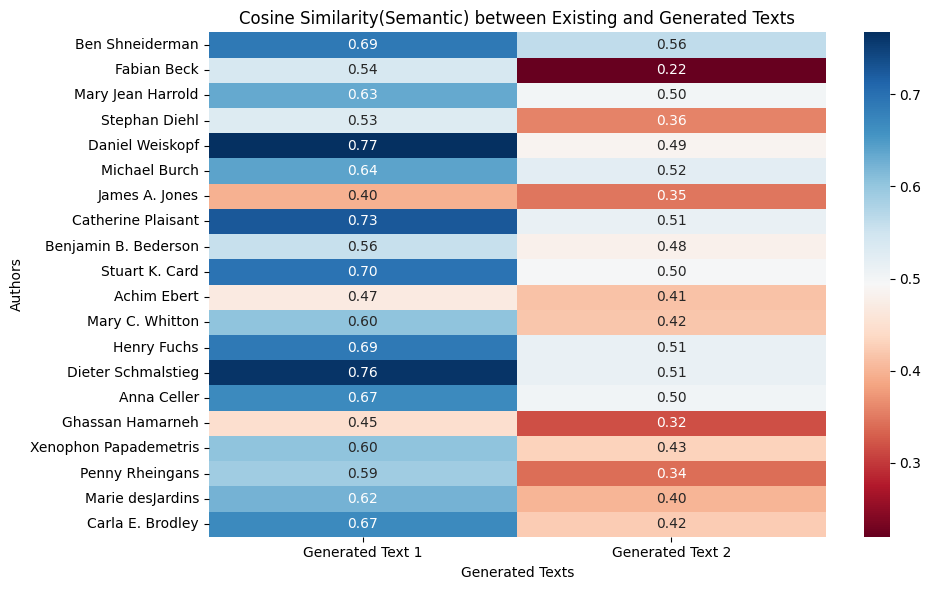

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# Download NLTK data if not already downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Custom tokenizer that splits on whitespace
def tokenizer(text):
    return text.split()

# Step 1: Load the data from JSON
with open("RandomNamesNEW.json", 'r') as json_file:
    data = json.load(json_file)

# List to store cosine similarity scores for each entry
cosine_sims = []
author_names = []

# Dictionary to store results for adjectives and pronouns
results_dict = {}

# Iterate over each entry in the JSON data
for entry in data:
    author_name = entry['name']
    existing_text = entry['existing_text']
    generated_texts = [entry['generated_text1'], entry['generated_text2']]

    # Remove empty documents
    existing_text = existing_text.strip()
    generated_texts = [text.strip() for text in generated_texts]

    # Tokenize and tag the words in existing and generated texts
    existing_tokens = pos_tag(word_tokenize(existing_text))
    generated_tokens = [pos_tag(word_tokenize(text)) for text in generated_texts]

    # Create TfidfVectorizer object with custom tokenizer
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

    # Fit and transform the existing and generated texts
    tfidf_existing = vectorizer.fit_transform([existing_text])
    tfidf_generated = vectorizer.transform(generated_texts)

    # Calculate the cosine similarity for each generated text
    cosine_sims_entry = cosine_similarity(tfidf_existing, tfidf_generated)[0]
    cosine_sims.append(cosine_sims_entry)
    author_names.append(author_name)

    # Collect adjectives and pronouns for each generated text
    generated_results = []
    for generated_token_list in generated_tokens:
        pronouns = []
        adjectives = []

        for token, tag in generated_token_list:
            if tag in ['PRP', 'PRP$', 'WP', 'WP$']:  # Pronouns
                pronouns.append(token)
            elif tag.startswith('JJ'):  # Adjectives
                adjectives.append(token)

        generated_results.append({"pronouns": pronouns, "adjectives": adjectives})

    results_dict[author_name] = generated_results

# Convert results dictionary to JSON and save to a file
with open("generated_results.json", 'w') as json_output:
    json.dump(results_dict, json_output, indent=4)

# Convert cosine similarity data and author names to numpy arrays for plotting the heatmap
cosine_sims_np = np.array(cosine_sims)
author_names_np = np.array(author_names)

# Set up the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cosine_sims_np, cmap='RdBu', annot=True, fmt='.2f', xticklabels=[f'Generated Text {i+1}' for i in range(2)], yticklabels=author_names_np)
plt.xlabel('Generated Texts')
plt.ylabel('Authors')
plt.title('Cosine Similarity(Semantic) between Existing and Generated Texts')
plt.tight_layout()

# Show the plot
plt.show()


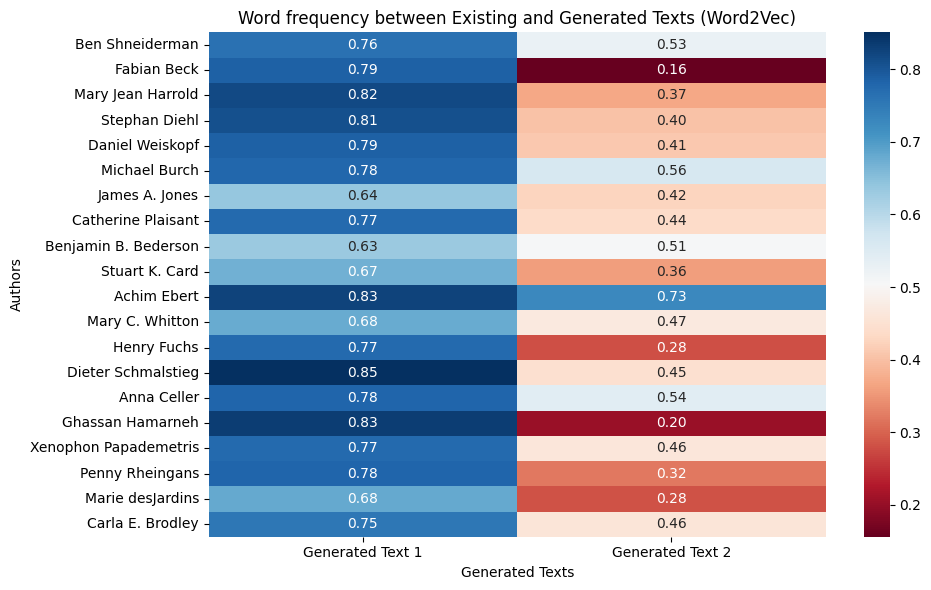

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

# Custom tokenizer that splits on whitespace, removes punctuation, and converts to lowercase
def tokenizer(text):
    return [token.lower() for token in text.split() if token.isalpha()]

# Step 1: Load the data from JSON
with open("RandomNamesNEW.json", 'r') as json_file:
    data = json.load(json_file)

# List to store cosine similarity scores for each entry
cosine_sims = []
author_names = []

# Create Word2Vec model
word2vec_model = Word2Vec([tokenizer(entry['existing_text']) for entry in data], vector_size=100, window=5, min_count=1, workers=4)

# Iterate over each entry in the JSON data
for entry in data:
    author_name = entry['name']
    existing_text = entry['existing_text']
    generated_texts = [entry['generated_text1'], entry['generated_text2']]

    # Remove empty documents
    existing_text = existing_text.strip()
    generated_texts = [text.strip() for text in generated_texts]

    # Get embeddings for existing and generated texts
    existing_emb = np.mean([word2vec_model.wv[token] for token in tokenizer(existing_text) if token in word2vec_model.wv], axis=0)
    generated_embs = [np.mean([word2vec_model.wv[token] for token in tokenizer(text) if token in word2vec_model.wv], axis=0) for text in generated_texts]

    # Check if there are valid embeddings for both existing and generated texts
    if np.isnan(existing_emb).any() or any(np.isnan(emb).any() for emb in generated_embs):
        # Set similarity scores to 0 or any other suitable value when embeddings are not valid
        cosine_sims_entry = [0] * 4
    else:
        # Calculate the cosine similarity for each generated text
        cosine_sims_entry = [cosine_similarity([existing_emb], [generated_emb])[0][0] for generated_emb in generated_embs]

    cosine_sims.append(cosine_sims_entry)
    author_names.append(author_name)

# Convert cosine similarity data and author names to numpy arrays for plotting the heatmap
cosine_sims_np = np.array(cosine_sims)
author_names_np = np.array(author_names)

# Set up the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cosine_sims_np, cmap='RdBu', annot=True, fmt='.2f', xticklabels=[f'Generated Text {i+1}' for i in range(2)], yticklabels=author_names_np)
plt.xlabel('Generated Texts')
plt.ylabel('Authors')
plt.title('Word frequency between Existing and Generated Texts (Word2Vec)')
plt.tight_layout()

# Show the plot
plt.show()


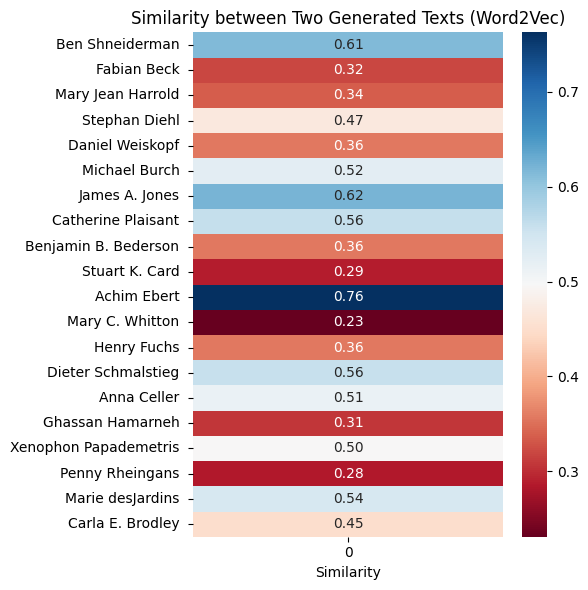

In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec


# Custom tokenizer that splits on whitespace, removes punctuation, and converts to lowercase
def tokenizer(text):
    return [token.lower() for token in text.split() if token.isalpha()]

# Step 1: Load the data from JSON
with open("RandomNamesNEW.json", 'r') as json_file:
    data = json.load(json_file)

# List to store cosine similarity scores for each entry
cosine_sims = []
author_names = []

# Create Word2Vec model
word2vec_model = Word2Vec([tokenizer(entry['existing_text']) for entry in data], vector_size=100, window=5, min_count=1, workers=4)

# Iterate over each entry in the JSON data
for entry in data:
    author_name = entry['name']
    existing_text = entry['existing_text']
    generated_texts = [entry['generated_text1'], entry['generated_text2']]

    # Remove empty documents
    existing_text = existing_text.strip()
    generated_texts = [text.strip() for text in generated_texts]

    # Get embeddings for existing and generated texts
    existing_emb = np.mean([word2vec_model.wv[token] for token in tokenizer(existing_text) if token in word2vec_model.wv], axis=0)
    generated_embs = [np.mean([word2vec_model.wv[token] for token in tokenizer(text) if token in word2vec_model.wv], axis=0) for text in generated_texts]

    # Check if there are valid embeddings for both existing and generated texts
    if np.isnan(existing_emb).any() or any(np.isnan(emb).any() for emb in generated_embs):
        # Set similarity scores to 0 or any other suitable value when embeddings are not valid
        cosine_sims_entry = [0, 0]
    else:
        # Calculate the cosine similarity between the two generated texts
        cosine_sims_entry = cosine_similarity([generated_embs[0]], [generated_embs[1]])[0][0]

    cosine_sims.append(cosine_sims_entry)
    author_names.append(author_name)

# Convert cosine similarity data and author names to numpy arrays for plotting the heatmap
cosine_sims_np = np.array(cosine_sims)
author_names_np = np.array(author_names)

# Set up the heatmap
plt.figure(figsize=(6, 6))  # Adjust the figure size to accommodate two generated texts
sns.heatmap(cosine_sims_np[:, np.newaxis], cmap='RdBu', annot=True, fmt='.2f', yticklabels=[f'{author} ' for author in author_names_np])
plt.xlabel('Similarity')
plt.title('Similarity between Two Generated Texts (Word2Vec)')
plt.tight_layout()

# Show the plot
plt.show()